# ROME skills

Author: Stephan <stephan@bayesimpact.org>

Date: Jun 14, 2016

We want to allow our users to build a profile of skills they have, in order to suggest suitable jobs to them. A PRD for this feature can be found at http://go/pe:profile-prd. 

We want to use the skills taxonomy from the ROME dataset because it allows us to extract a mapping from skills to jobs. The main questions we want to answer in this notebook are:

* How many different skills do we have in total?
* How many skills are common for a job?
* Any other properties of the skills dataset?
* Are some skills more unique to a job than others?
* TODO: Are there jobs that have the exact same set of skills?

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as _

from bob_emploi.lib import read_data
from bob_emploi.lib import plot_helpers

Before using the XML version of the data, I had a look at the CSV data. I saw that i could use `unix_coherence_item_v329_utf8` to establish a mapping between job_groups and skills, however I saw that the XML data contains this ordering of skills. I thought it could be quite useful, if that actually represents a ordering from more to less specific. That is why I used the XML version of the data in this case.

In [2]:
fiche_dicts = read_data.load_fiches_from_xml('../../../data/ficheMetierXml')
rome = [read_data.fiche_extractor(f) for f in fiche_dicts]
skills_data = [dict(skill, code_rome=job['code_rome'], job_group_name=job['intitule'])
               for job in rome
               for skill in job['skills']]
skills_raw = pd.DataFrame(skills_data)
skills_raw.columns = ['skill_id', 'job_group_id', 'type', 'job_group_name', 'name', 'position', 'priorisation']

## Overview of dataset structure

A peek at the raw data.

In [3]:
skills_raw.head()

,skill_id,job_group_id,type,job_group_name,name,position,priorisation
0,22757,A1101,1,Conduite d'engins agricoles et forestiers,Techniques culturales,1,1
1,21882,A1101,1,Conduite d'engins agricoles et forestiers,Eléments de base en mécanique générale,2,1
2,21875,A1101,1,Conduite d'engins agricoles et forestiers,Eléments de base en hydraulique,3,1
3,21905,A1101,1,Conduite d'engins agricoles et forestiers,Eléments de base en pneumatique,4,1
4,22230,A1101,1,Conduite d'engins agricoles et forestiers,Normes environnementales,5,1


In [4]:
skills_raw.describe().transpose()

,count,unique,top,freq
skill_id,5520,1741,21467,164
job_group_id,5520,531,I1306,22
type,5520,2,1,3964
job_group_name,5520,531,Installation et maintenance d'automatismes,22
name,5520,1741,Utilisation d'outils bureautiques (traitement ...,164
position,5520,17,1,1003
priorisation,5520,1,1,5520


So we got 1741 different skills for the 531 different job groups in ROME. They are of two different types where one of them makes up about 70% of all skill occurrences (3964 / 5520). The most common skill is *Utilisation d'outils bureautiques...*. The `position` column suggests that they are ordered and the `priorisation` column does not contain any information.

Let's clean up the data a little and look at the distribution of skill type on the deduplicated list of skills. With that I mean just investigating the list of 1741 unique skills, instead of skills being associated with jobs as in the table above.

In [5]:
# Mapping extracted from data/rome/csv/unix_referentiel_competence_v329_utf8.csv
COMPETENCE_TYPES = {
    '1': 'theoretical_skill',
    '2': 'action_skill'
}

skills = skills_raw.drop(['priorisation'], axis=1)
skills['type'] = skills.type.map(COMPETENCE_TYPES)
skills['position'] = skills.position.astype(int)

In [6]:
dedup_skills = skills.drop_duplicates(subset=['skill_id'])
dedup_skills['type'].value_counts(normalize=True)

theoretical_skill    0.722573
action_skill         0.277427
Name: type, dtype: float64

The distribution of theoretical to action skills is present also in the deduplicated list of skills, not only in the skills associated to jobs.

Just as a sanity check, make sure that each skill is only associated with one type.

In [7]:
skills.groupby('skill_id')['type'].nunique().value_counts()

1    1741
Name: type, dtype: int64

Good!

## Ordering of skills

Does that ordering actually play a role?

Let's first check whether the position is unique per `job_group` or per `job_group` and `type`. From looking at the XML it looks like there are individual orderings per `type`, but I want to make sure.

In [8]:
skills.duplicated(subset=['job_group_id', 'type', 'position']).sum()

0

In [9]:
skills.duplicated(subset=['job_group_id', 'position']).sum()

1486

Skills are ordered separately for the two types of skills.

#### are the skills higher up in the ordering maybe more specific to a certain job_group?

In [10]:
skills = skills.sort_values('position')
first = skills.groupby(['job_group_name', 'type']).first().name
last = skills.groupby(['job_group_name', 'type']).last().name
pd.concat([first, last], axis=1, keys=['first', 'last'])

first  \
job_group_name                                     type                                                                   
Abattage et découpe des viandes                    action_skill                                  Aiguisage des couteaux   
                                                   theoretical_skill  Règles d'hygiène et de sécurité alimentaire Ha...   
Accompagnement de voyages, d'activités culturel... theoretical_skill      Règles de sécurité des biens et des personnes   
Accompagnement et médiation familiale              theoretical_skill                                        Droit civil   
Accompagnement médicosocial                        action_skill       Identification des signes et du degré de la do...   
                                                   theoretical_skill                Eléments de base en psychomotricité   
Accueil et renseignements                          action_skill                                     Veille documentaire   
                                                   theoretical_skill                                Modalités d'accueil   
Accueil et services bancaires                      action_skill                                  Rédaction de documents   
                                                   theoretical_skill                                  Modes de paiement   
Accueil touristique                                action_skill                                     Veille documentaire   
                                                   theoretical_skill         Caractéristiques des produits touristiques   
Achat vente d'objets d'art, anciens ou d'occasion  action_skill                               Argumentation commerciale   
                                                   theoretical_skill                    Histoire de l'art et des styles   
Achats                                             action_skill                               Argumentation commerciale   
                                                   theoretical_skill                           Code des marchés publics   
Action sociale                                     theoretical_skill      Caractéristiques socioculturelles des publics   
Administration de systèmes d'information           action_skill                                  Rédaction de documents   
                                                   theoretical_skill                                      Algorithmique   
Administration des ventes                          action_skill       Utilisation d'outils bureautiques (traitement ...   
                                                   theoretical_skill                                   Droit commercial   
Affrètement transport                              action_skill       Utilisation d'outils bureautiques (traitement ...   
                                                   theoretical_skill        Réglementation du transport de marchandises   
Aide agricole de production fruitière ou viticole  action_skill                  Utilisation d'outils manuels agricoles   
                                                   theoretical_skill                    Règles d'hygiène et de sécurité   
Aide agricole de production légumière ou végétale  action_skill                  Utilisation d'outils manuels agricoles   
                                                   theoretical_skill                    Règles d'hygiène et de sécurité   
Aide aux bénéficiaires d'une mesure de protecti... theoretical_skill                                        Droit civil   
Aide aux soins animaux                             theoretical_skill                                   Biologie animale   
Aide d'élevage agricole et aquacole                theoretical_skill                    Règles d'hygiène et de sécurité   
...                                                                                                                 ...   
Éducation de jeunes enfants                        acti

Feedback I got from Pascal: I'm sorry but even if I read French quite fluently I cannot tell whether they are ordered, so I believe they are not.
"Éducation de jeunes enfants" (young kinds education), has its first theoritical skill being "Civil Law" and its last "Technics of listening and realtion to people": I believe the last one is more correlated to the job group.
"Élevage ovin ou caprin" (Breeding of sheep or goats) has its first action skill being "Setup of birth cages", and the last one "welding". I believe the first one is more correlated to the job group.

TODO: 

However I feel that we can compute some interesting measure of it:
1. assign a specificity score to each skill by computing some reverse function of its frequency among job groups (1 / # of job groups with this skill)
2. normalize positions from 0 to 1 for each job group
3. plot 1 & 2 and see if there's any kind of correlation
Supposedly we should see very specific skills being closer to 0.

To make it even closer to something useful, you can also weigh each job group with the number of persons in this job group, for instance using a proxy with the FHS.

## Skills per job

How many different skills are usually associated to a job?

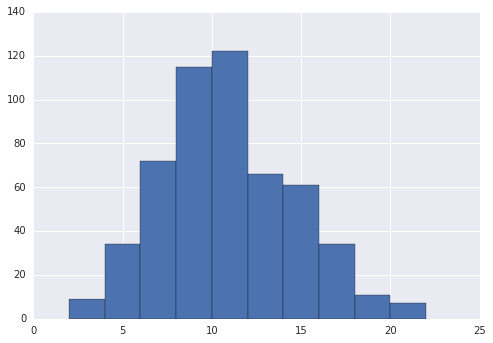

In [11]:
_ = skills.groupby('job_group_id').skill_id.nunique().hist()

That's a neat distribution with a clear peak around 10. Florian asked in the PRD 'how many skills do we plan to collect per user'. With users having had several jobs in their past, I would expect a user to pick between 15-30 skills, as a very rough estimate. This of course also depends on the typical skill overlap between jobs and a probobably higher skill overlap between jobs in the same field.

Also, as we saw in the summary statistics above, all 531 job groups in ROME have at least one skill associated with it.

**Is there a difference between the number of theoretical and action skills?**

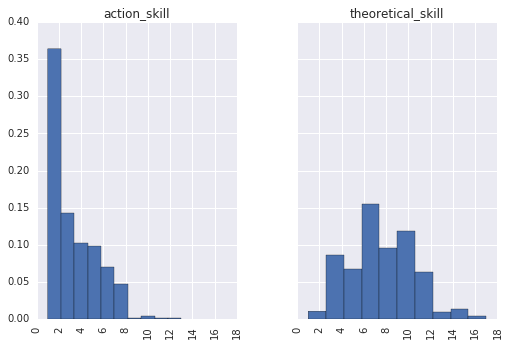

In [12]:
by_job_by_type = skills.groupby(['job_group_id', 'type'])
unique_job_counts = by_job_by_type.skill_id.nunique().reset_index()
_ = unique_job_counts.hist(by='type', normed=True, sharex=True, sharey=True)

The theoretical skills resemble the above distribution, but many jobs seem to have only one or two action skills.

## Let's see how specific skills are to a job group.

Because each skill only appears once per job_group, I can simply divide the skill frequency by number of job_groups.

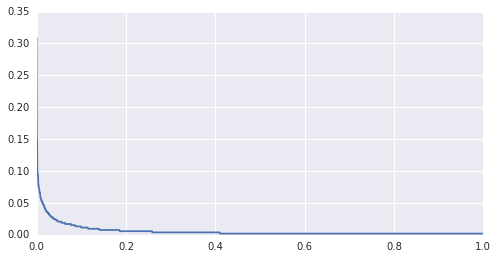

In [13]:
skill_frequency = skills.name.value_counts() / skills.job_group_id.nunique()
skill_frequency.index = pd.Series(range(len(skill_frequency))) / len(skill_frequency)
_ = skill_frequency.plot(figsize=(8, 4))

There seem to be a very few skills that are associated with lots of different jobs. Most of the skills seem to be very specific to a job. 

That means that we might have trouble suggesting totally new jobs for the skills a user imported from their old job, because there might be hardly any overlap between skills of his old job and a potential new job. Except of the few very common skills that probably don't provide much signal.

**What are those very common skills?**

In [14]:
counts = skills.groupby(['name', 'type']).skill_id.count().to_frame()
counts.sort_values('skill_id', ascending=False).head(10)

,,skill_id
name,type,
"Utilisation d'outils bureautiques (traitement de texte, tableur,...)",action_skill,164
Normes qualité,theoretical_skill,82
Règles de sécurité,theoretical_skill,79
Techniques commerciales,theoretical_skill,52
Techniques de communication,theoretical_skill,52
Règles et consignes de sécurité,theoretical_skill,50
Gestes et postures de manutention,theoretical_skill,47
Lecture de plan,action_skill,41
Eléments de base en mécanique générale,theoretical_skill,41


Looks like very general soft skills.

## Skills spread over categories?

Paul asked: check if a given skill is present across many different job categories (look at the first letter of ROME for example) -> possible there's a bias towards only reusing the exact same skill if the jobs belong in the same job category, which would defeat some of the purpose.

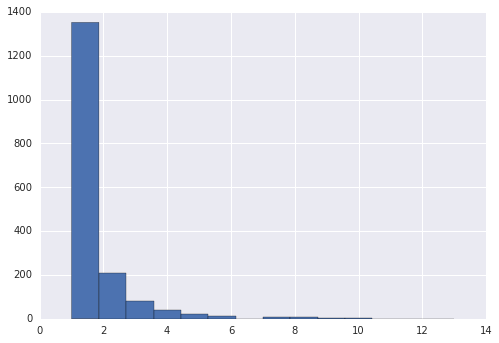

In [15]:
skills['category'] = skills.job_group_id.str.slice(0, 1)
_ = skills.groupby('name').category.nunique().hist(bins=14)

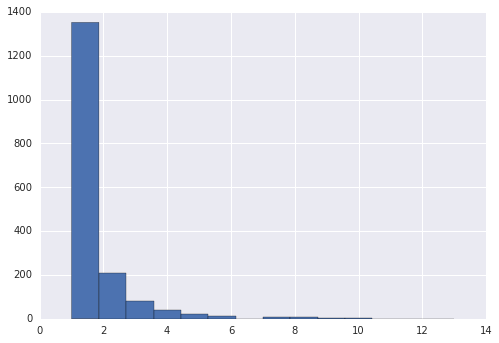

In [16]:
_ = skills.groupby(['name', 'type']).category.nunique().hist(bins=14)

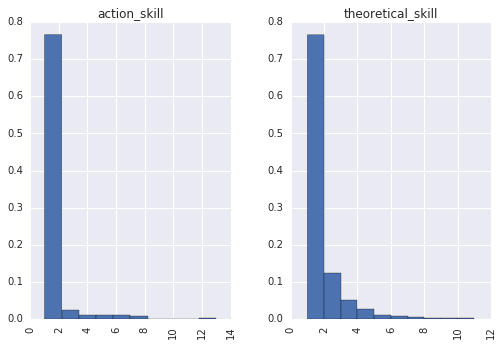

In [17]:
_ = skills.groupby(['name', 'type']).category.nunique().reset_index().hist(by='type', normed=True)

Most skills are only used within the same ROME category. However theoretical skills are more spread over categories than practical skills are.

## Conclusion

* We have a list of ~1700 skills that are divided into theoretical and action skills.
* Theoretical skills are more common (~70%).
* Skills are ordered within a job_group, we need to confirm that this ordering is related to specificity of a skill.
* There are on average ~12 different skills assigned to a job.
* Most skills are pretty specific to a job_group.
* Most skills are specific to the ROME category.